# Session classifier

We attempt to build a session classifier by the same construction (in particular, HuBERT) as for the label classifier, to see if the same transformer is actually picking up on sessions.


In [ ]:
# Get the data

! gdown 1e3ilpZosYjvGzjmO1Jaur6Ln4cJD8yAm
! tar -xf recanvo.tar.gz
! rm recanvo.tar.gz
! mv recanvo data

Downloading...
From (original): https://drive.google.com/uc?id=1e3ilpZosYjvGzjmO1Jaur6Ln4cJD8yAm
From (redirected): https://drive.google.com/uc?id=1e3ilpZosYjvGzjmO1Jaur6Ln4cJD8yAm&confirm=t&uuid=e7a0aa97-303e-4616-bc73-a5cbd2d973d1
To: /content/recanvo.tar.gz
100% 1.06G/1.06G [00:11<00:00, 91.9MB/s]


In [ ]:
# Update/install packages.

! pip install -U scikit-learn
! pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 61.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 1.2 MB/s eta 0:00:00


In [ ]:
import functools
from pathlib import Path


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    f1_score,
    log_loss,
    recall_score,
)
from sklearn.model_selection import (
    cross_val_predict,
    StratifiedKFold,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
import torch
import torchaudio
from tqdm.notebook import tqdm


def to_prob(metric):
    @functools.wraps(metric)
    def metric_that_takes_prob(y_actual, y_pred, sample_weight=None):
        return metric(y_actual, y_pred.argmax(1), sample_weight=sample_weight)

    return metric_that_takes_prob


metrics = {
    "accuracy": to_prob(accuracy_score),
    "balanced_accuracy": to_prob(balanced_accuracy_score),
    "unweighted_f1": to_prob(functools.partial(f1_score, average="macro")),
    "UAR": to_prob(functools.partial(recall_score, average="macro")),
    "logloss": log_loss,
}

In [ ]:
data_loc = Path('data/wav')
csv_loc = Path('directory_w_train_test.csv')

assert csv_loc.exists(), f'No metadata file found at `{csv_loc}`. Please upload it and try again.'

In [ ]:
# Pretrained HuBERT model
bundle = torchaudio.pipelines.HUBERT_BASE
model = bundle.get_model()

Downloading: "https://download.pytorch.org/torchaudio/models/hubert_fairseq_base_ls960.pth" to /root/.cache/torch/hub/checkpoints/hubert_fairseq_base_ls960.pth
100%|██████████| 360M/360M [00:01<00:00, 226MB/s]


In [ ]:
participant = 'P05'

In [ ]:
# A little utility function to extract the session from a file name.

def get_session(filename: str) -> str:
  return filename.split('-')[0][:-3]

In [ ]:
# List of all data files
data_files = pd.read_csv(csv_loc)

# Dataframe restricted to the selected participant
data_files_participant = data_files #.loc[data_files.Participant == participant]
data_files_participant['Session'] = data_files_participant.Filename.apply(get_session)

# Further restrict to sessions with sufficiently many samples
training_files = data_files_participant.loc[
    data_files_participant.is_test == 0
].copy()
session_counts = training_files.Session.value_counts()
training_files = training_files.loc[
    training_files.Session.isin(session_counts[session_counts >= 20].index)
]

# label_counts = data_files_p5.Label.value_counts()
# training_files = data_files_p5.loc[
#     data_files_p5.Label.isin(label_counts[label_counts >= 30].index)
#     & (data_files_p5.is_test == 0)
# ].copy()
# training_files["session"] = training_files.Filename.apply(
#     lambda name: name.split("-")[0][:-3]
# )

display(training_files.Session.value_counts())

,count
Session,
210113_1909,413
200306_2024,196
200605_1745,153
200411_1548,134
200206_0804,131
...,...
200929_2203,21
200202_1112,21
200815_2140,20


In [ ]:
# Extract acoustic features from one wav file using
# the pretrained

filename = training_files.Filename.iloc[0]
waveform, sample_rate = torchaudio.load(data_loc / filename)
waveform = torchaudio.functional.resample(
    waveform, sample_rate, bundle.sample_rate
)
features, _ = model.extract_features(waveform)

# features is a list of 12 tensors, each having shape
# (m, n, 768), where the value of m and n are different
# depending on the audio sample (m is always 1 or 2, n
# varies more widely and I think depends on the length
# of the clip). I'm averaging over time (n).
print(f"{type(features)=}, {len(features)=}")
print(features[0].mean((0, 1)).shape)

type(features)=<class 'list'>, len(features)=12
torch.Size([768])


In [10]:
# Generate features using the pretrained model.
# We will use only the first layer of generated features.
with torch.no_grad():
    t_list = []
    for filename in tqdm(training_files.Filename):
        waveform, sample_rate = torchaudio.load(data_loc / filename)
        waveform = torchaudio.functional.resample(
            waveform, sample_rate, bundle.sample_rate
        )

        features, _ = model.extract_features(waveform)
        t_list.append(features[0].mean((0, 1)))

  0%|          | 0/4856 [00:00<?, ?it/s]

In [11]:
# Vectorize "features" and "labels"

X = torch.stack(t_list).detach()

sessions = training_files.Session.unique()

y = torch.zeros(len(training_files), dtype=torch.int)
for idx, session in enumerate(sessions):
    y[(training_files.Session == session).values] = idx
print(X.shape, y.shape)

torch.Size([4856, 768]) torch.Size([4856])


In [12]:
# There are 768 generated features, which is a lot
# relative to how many training data there are. So we
# will need regularization. Using sk-optimize to optimize
# strength of regularization parameter (this is overkill
# since there's just one parameter, but oh well)
est = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        max_iter=10**6,
    ),
)
opt = BayesSearchCV(
    est,
    {
        "logisticregression__C": (5e-3, 1, "log-uniform"),
    },
    n_iter=20,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=12345),
    scoring="accuracy",
)
opt.fit(
    X.reshape(len(X), -1),
    y,
)
print(opt.best_params_)
print("Best accuracy:", opt.best_score_)

OrderedDict([('logisticregression__C', 0.45304632218551794)])
Best accuracy: 0.6622722837384922


In [13]:
# Some possible sample weights for training and/or metrics.
# session_weight weights each sample based on sessions, so
# that the total weight of observations in each sesion is
# constant. On top of that, session_and_label_weight assigns
# a label to each weight, which is multiplied by the sesion weight,
# in such a way to make the sum of the weights constant by label.
session_weight = (
    (1 / training_files.Session.value_counts())
    .clip(None, 0.1)
    .loc[training_files.Session]
).values
session_and_label_weight = (
    1
    / pd.Series(session_weight, training_files.index)
    .groupby(training_files.Label)
    .sum()
).loc[training_files.Label].values * session_weight

In [14]:
# Generate out-of-sample predictions using a logistic
# regression model, with the parameter determined by
# the optimization above.
#
# We compute various metrics, using various weightings
est = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        C=opt.best_params_["logisticregression__C"],
        max_iter=10**6,
    ),
)

oos_pred_prob = cross_val_predict(
    est,
    X.reshape(len(X), -1),
    y,
    cv=StratifiedKFold(
        n_splits=10,
        shuffle=True,
        random_state=1234,  # Using different seed to avoid over-fitting parameter
    ),
    method="predict_proba",
    params={"logisticregression__sample_weight": session_weight},
)
oos_pred = oos_pred_prob.argmax(1)

display(
    pd.Series(
        {name: metric(y, oos_pred_prob) for name, metric in metrics.items()},
        name="no_weight",
    ).round(3)
)
display(
    pd.Series(
        {
            name: metric(y, oos_pred_prob, sample_weight=session_weight)
            for name, metric in metrics.items()
        },
        name="session_weight",
    ).round(3)
)
display(
    pd.Series(
        {
            name: metric(
                y, oos_pred_prob, sample_weight=session_and_label_weight
            )
            for name, metric in metrics.items()
        },
        name="session_and_label_weight",
    ).round(3)
)

,no_weight
accuracy,0.597
balanced_accuracy,0.611
unweighted_f1,0.578
UAR,0.611
logloss,1.549


,session_weight
accuracy,0.611
balanced_accuracy,0.611
unweighted_f1,0.608
UAR,0.611
logloss,1.531


,session_and_label_weight
accuracy,0.538
balanced_accuracy,0.595
unweighted_f1,0.505
UAR,0.595
logloss,1.832


In [15]:
# Confusion matrix
# selftalk and delighted are frequently confused by this model
conf_matrix_df = pd.DataFrame(
    confusion_matrix(y, oos_pred), columns=sessions, index=sessions
)
conf_matrix_df.index.name = "actual_label"
conf_matrix_df.columns.name = "pred_label"
display(conf_matrix_df)

pred_label,200126_2142,200302_2156,200306_2047,200229_2156,200309_2035,200529_1029,200316_1751,200124_1828,200307_1850,210408_2025,...,210201_1420,210201_1423,210302_1506,210201_1416,210113_1436,210216_0947,210216_1046,210216_0944,210201_1427,210112_1705
actual_label,,,,,,,,,,,,,,,,,,,,,
200126_2142,49,0,2,2,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
200302_2156,0,33,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
200306_2047,3,1,31,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
200229_2156,5,0,0,20,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
200309_2035,0,0,0,0,58,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210216_0947,0,0,0,0,0,0,0,0,0,0,...,0,2,0,1,1,19,2,11,1,0
210216_1046,0,0,0,0,0,0,0,0,0,0,...,1,3,0,0,1,1,15,2,0,0
210216_0944,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,8,1,14,0,1


<Axes: xlabel='pred_label', ylabel='actual_label'>

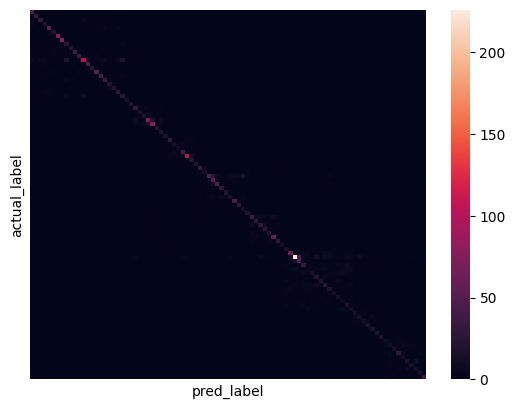

In [18]:
import seaborn as sns
sns.heatmap(conf_matrix_df, yticklabels=False, xticklabels=False)

In [ ]:
# Hold one session out CV
# Performance is substantially worse, so the model
# is probably picking up on background sounds. But
# there is still some predictive power.

# Here I'm running the CV for many different values
# of the regularization parameter C, and logging
# some different scores. Optimal value of C depends
# on whether whether metrics weight classes by class
# size.
scores = []

# C_list = [0.02 * 0.8**n for n in range(20)]
# for C in tqdm(C_list):
C = 0.007
pred_prob = np.zeros((len(X), len(labels)))
pred_prob[:] = np.nan
for session in training_files.session.unique():
    mask = (training_files.session == session).values
    est = make_pipeline(
        StandardScaler(),
        LogisticRegression(
            C=C,
            max_iter=10**6,
        ),
    )
    est.fit(
        X[~mask],
        y[~mask],
    )
    pred_prob[mask] = est.predict_proba(X[mask])
assert not np.isnan(pred_prob).any()
pred = pred_prob.argmax(1)
display(
    pd.Series(
        {name: metric(y, pred_prob) for name, metric in metrics.items()},
        name="no_weight",
    ).round(3)
)
print()
display(
    pd.Series(
        {
            name: metric(y, pred_prob, sample_weight=session_weight)
            for name, metric in metrics.items()
        },
        name="session_weight",
    ).round(3)
)
print()
display(
    pd.Series(
        {
            name: metric(y, pred_prob, sample_weight=session_and_label_weight)
            for name, metric in metrics.items()
        },
        name="session_and_label_weight",
    ).round(3)
)

,no_weight
accuracy,0.524
balanced_accuracy,0.445
unweighted_f1,0.456
UAR,0.445
logloss,1.258


,session_weight
accuracy,0.526
balanced_accuracy,0.458
unweighted_f1,0.466
UAR,0.458
logloss,1.206


,session_and_label_weight
accuracy,0.458
balanced_accuracy,0.458
unweighted_f1,0.444
UAR,0.458
logloss,1.432
